# Tree Packing Visualization and Metrics

This notebook visualizes Christmas tree packing solutions and tracks key metrics over time.


In [78]:
import sys
import os
import math
import random
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

# Add parent directory to path to import solution
# Notebook is in ipy/, solution is in py/nfp_blf_sa/
parent_dir = os.path.dirname(os.getcwd())
solution_path = os.path.join(parent_dir, 'py', 'nfp_blf_sa')
if not os.path.exists(solution_path):
    # Try alternative path
    solution_path = os.path.join('..', 'py', 'nfp_blf_sa')

sys.path.insert(0, solution_path)
from solution import ChristmasTree, compute_side_length

# Set precision for Decimal
getcontext().prec = 25
scale_factor = Decimal('1e15')

# Set pandas display options
pd.set_option('display.float_format', '{:.12f}'.format)
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")


Libraries imported successfully!


## CSV File Configuration


In [79]:
# Configure CSV file path
# You can change this to point to a different CSV file
#csv_path = "/Users/dn220800kmo/Documents/GIT/privit-elves-2025/DN220800KMO/py/nfp_blf_sa/nfp_blf_sa.csv"
csv_path = "/Users/dn220800kmo/Documents/GIT/privit-elves-2025/DN220800KMO/py/nfp_blf_sa ( not working ) /sample_submission.csv"
if not os.path.exists(csv_path):
    # Try alternative path
    csv_path = os.path.join('..', 'py', 'nfp_blf_sa', 'nfp_blf_sa.csv')

print(f"CSV file path: {csv_path}")
print(f"File exists: {os.path.exists(csv_path)}")


CSV file path: /Users/dn220800kmo/Documents/GIT/privit-elves-2025/DN220800KMO/py/nfp_blf_sa ( not working ) /sample_submission.csv
File exists: True


## Plotting Functions


In [80]:
def plot_trees(placed_trees, side_length, num_trees, title_suffix="", figsize=(12, 12), show_bounding_box=True):
    """
    Plot the arrangement of trees and the bounding square.
    
    Parameters:
    - placed_trees: List of ChristmasTree objects
    - side_length: Side length of the bounding square
    - num_trees: Number of trees to display
    - title_suffix: Additional text for the title
    - figsize: Figure size tuple
    - show_bounding_box: Whether to show the bounding square
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color scheme: gradient from blue to green to red
    colors = plt.cm.viridis([i / max(1, num_trees - 1) for i in range(num_trees)])
    
    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds
    
    # Plot each tree
    for i, tree in enumerate(placed_trees):
        # Rescale for plotting
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        ax.plot(x, y, color=colors[i], linewidth=0.5)
        ax.fill(x, y, alpha=0.6, color=colors[i], edgecolor='black', linewidth=0.3)
        
        # Optionally plot center point
        ax.plot(float(tree.center_x), float(tree.center_y), 'ko', markersize=2, alpha=0.5)
    
    # Calculate bounding square position
    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor
    
    width = maxx - minx
    height = maxy - miny
    
    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    
    # Draw bounding square
    if show_bounding_box:
        bounding_square = Rectangle(
            (float(square_x), float(square_y)),
            float(side_length),
            float(side_length),
            fill=False,
            edgecolor='red',
            linewidth=2.5,
            linestyle='--',
            label='Bounding Square'
        )
        ax.add_patch(bounding_square)
    
    # Set plot limits with padding
    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding)))
    )
    ax.set_ylim(
        float(square_y - Decimal(str(padding))),
        float(square_y + side_length + Decimal(str(padding)))
    )
    
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    
    title = f'{num_trees} Trees - Side Length: {side_length:.12f}'
    if title_suffix:
        title += f' {title_suffix}'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if show_bounding_box:
        ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    return fig, ax


## Metrics Calculation Functions


In [81]:
def calculate_metrics(placed_trees, side_length):
    """
    Calculate various metrics for the tree packing solution.
    
    Returns a dictionary with:
    - side_length: Bounding square side length
    - num_trees: Number of trees
    - total_area: Total area of all trees
    - bounding_area: Area of bounding square
    - efficiency: Percentage of bounding square filled
    - avg_distance_from_origin: Average distance of tree centers from origin
    - max_distance_from_origin: Maximum distance of tree centers from origin
    - std_distance_from_origin: Standard deviation of distances
    - kaggle_score: Normalized area metric (s^2 / n) for this configuration
    """
    num_trees = len(placed_trees)
    
    if num_trees == 0:
        return {
            'side_length': Decimal('0'),
            'num_trees': 0,
            'total_area': Decimal('0'),
            'bounding_area': Decimal('0'),
            'efficiency': Decimal('0'),
            'avg_distance_from_origin': Decimal('0'),
            'max_distance_from_origin': Decimal('0'),
            'std_distance_from_origin': Decimal('0'),
            'kaggle_score': Decimal('0')
        }
    
    # Calculate total tree area
    all_polygons = [t.polygon for t in placed_trees]
    total_area = Decimal(str(sum(p.area for p in all_polygons))) / (scale_factor ** 2)
    
    # Bounding square area
    bounding_area = side_length ** 2
    
    # Efficiency (fill percentage)
    efficiency = (total_area / bounding_area * 100) if bounding_area > 0 else Decimal('0')
    
    # Kaggle official metric: s^2 / n
    # Where s = side length of square bounding box, n = number of trees
    # This is the normalized area metric per configuration
    kaggle_score = (side_length ** 2) / num_trees if num_trees > 0 else Decimal('0')
    
    # Distance metrics from origin
    distances = []
    for tree in placed_trees:
        dist = (tree.center_x ** 2 + tree.center_y ** 2).sqrt()
        distances.append(float(dist))
    
    distances = np.array(distances)
    avg_distance = Decimal(str(np.mean(distances)))
    max_distance = Decimal(str(np.max(distances)))
    std_distance = Decimal(str(np.std(distances)))
    
    return {
        'side_length': side_length,
        'num_trees': num_trees,
        'total_area': total_area,
        'bounding_area': bounding_area,
        'efficiency': efficiency,
        'avg_distance_from_origin': avg_distance,
        'max_distance_from_origin': max_distance,
        'std_distance_from_origin': std_distance,
        'kaggle_score': kaggle_score
    }


## Load Solution from CSV and Track Metrics


Loading solution from: /Users/dn220800kmo/Documents/GIT/privit-elves-2025/DN220800KMO/py/nfp_blf_sa ( not working ) /sample_submission.csv
Processing CSV data...

Processed 10 trees - Side Length: 3.843449972485, Efficiency: 16.63%

Plotting 10 trees...


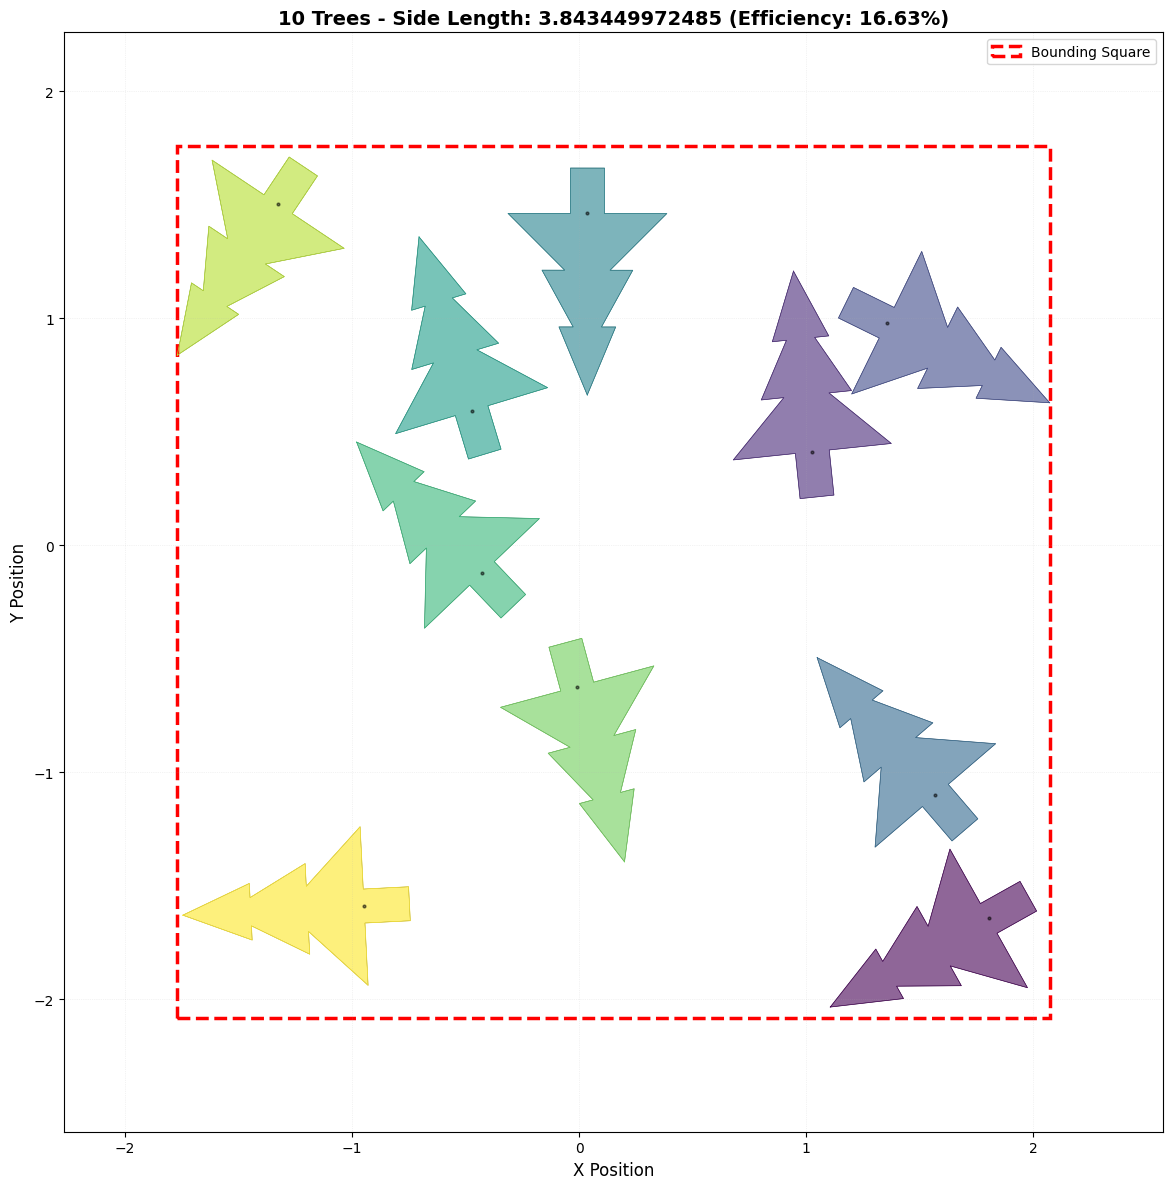

Processed 20 trees - Side Length: 4.104378007174, Efficiency: 29.16%

Plotting 25 trees...


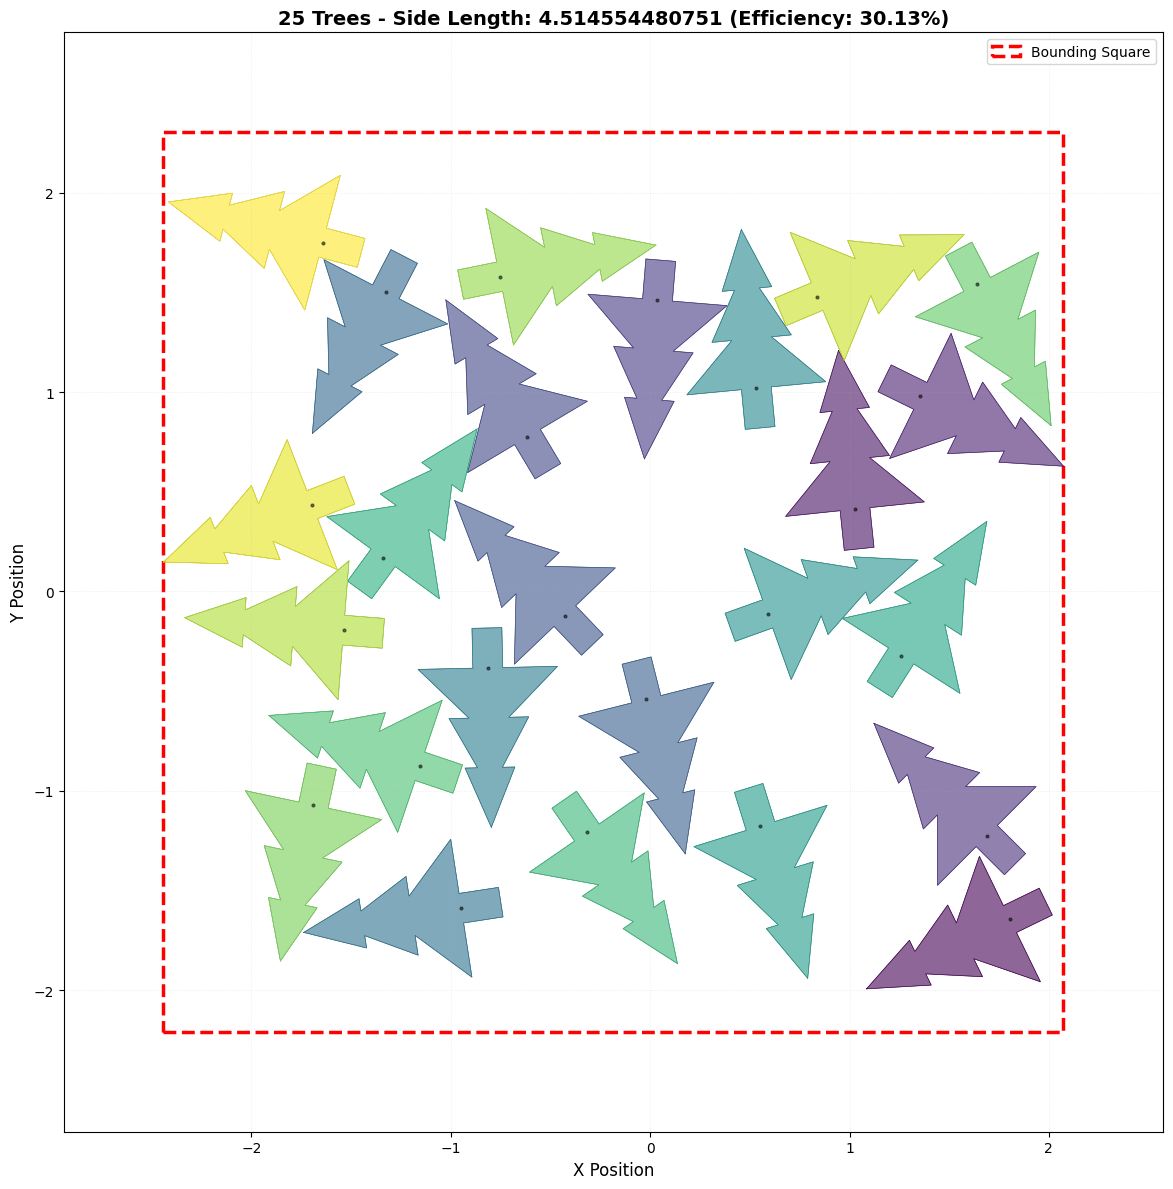

Processed 30 trees - Side Length: 5.087332103329, Efficiency: 28.47%
Processed 40 trees - Side Length: 5.614113555327, Efficiency: 31.17%
Processed 50 trees - Side Length: 6.451998118063, Efficiency: 29.50%

Plotting 50 trees...


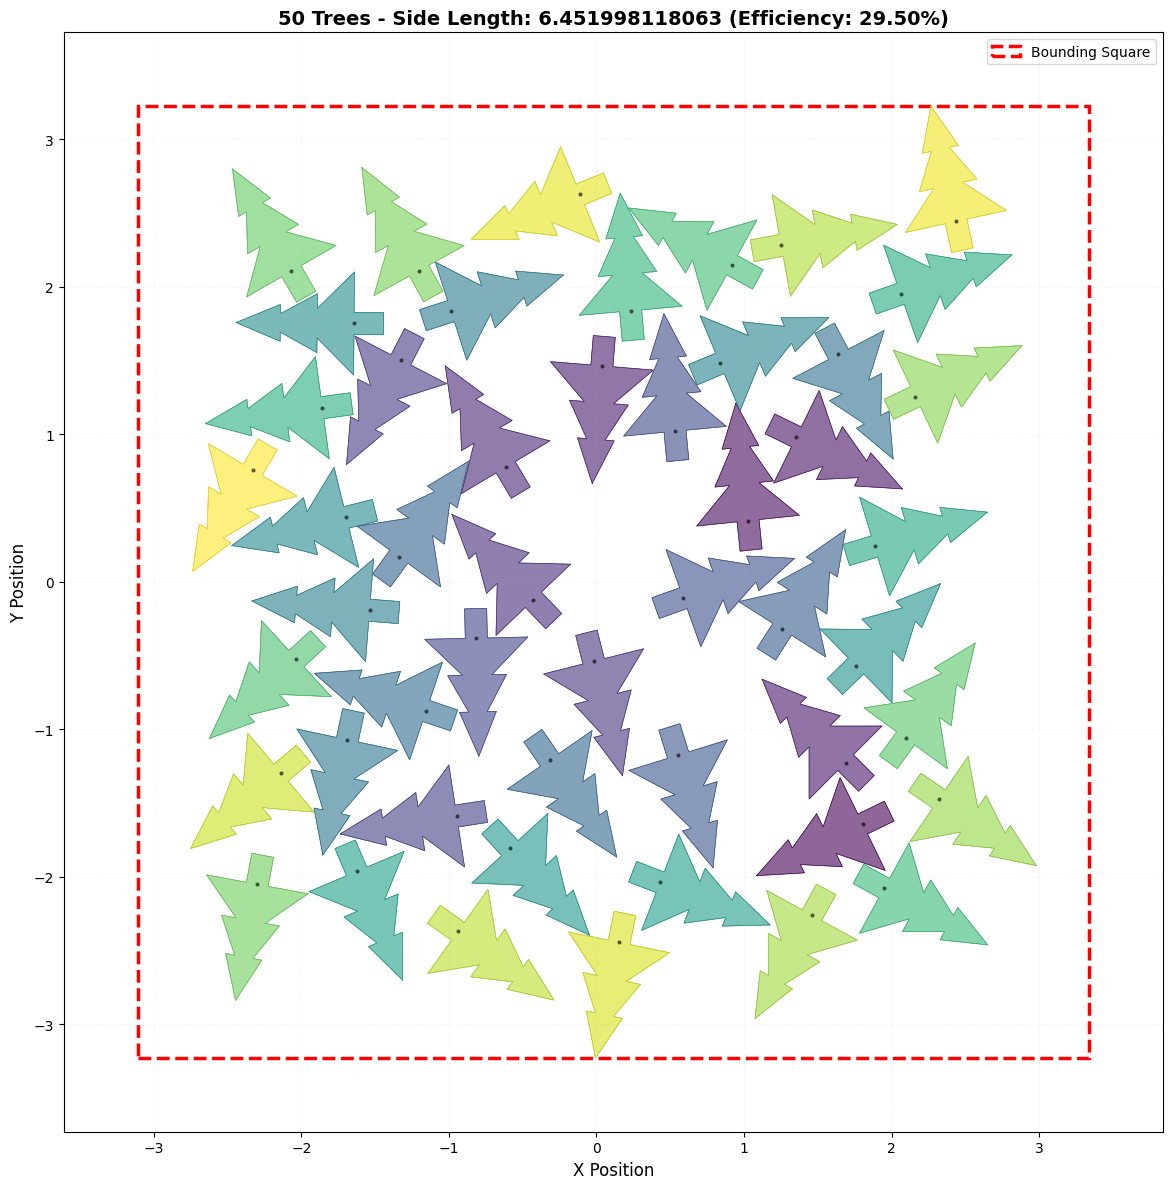

Processed 60 trees - Side Length: 6.671300596838, Efficiency: 33.11%
Processed 70 trees - Side Length: 7.248958489051, Efficiency: 32.72%

Plotting 75 trees...


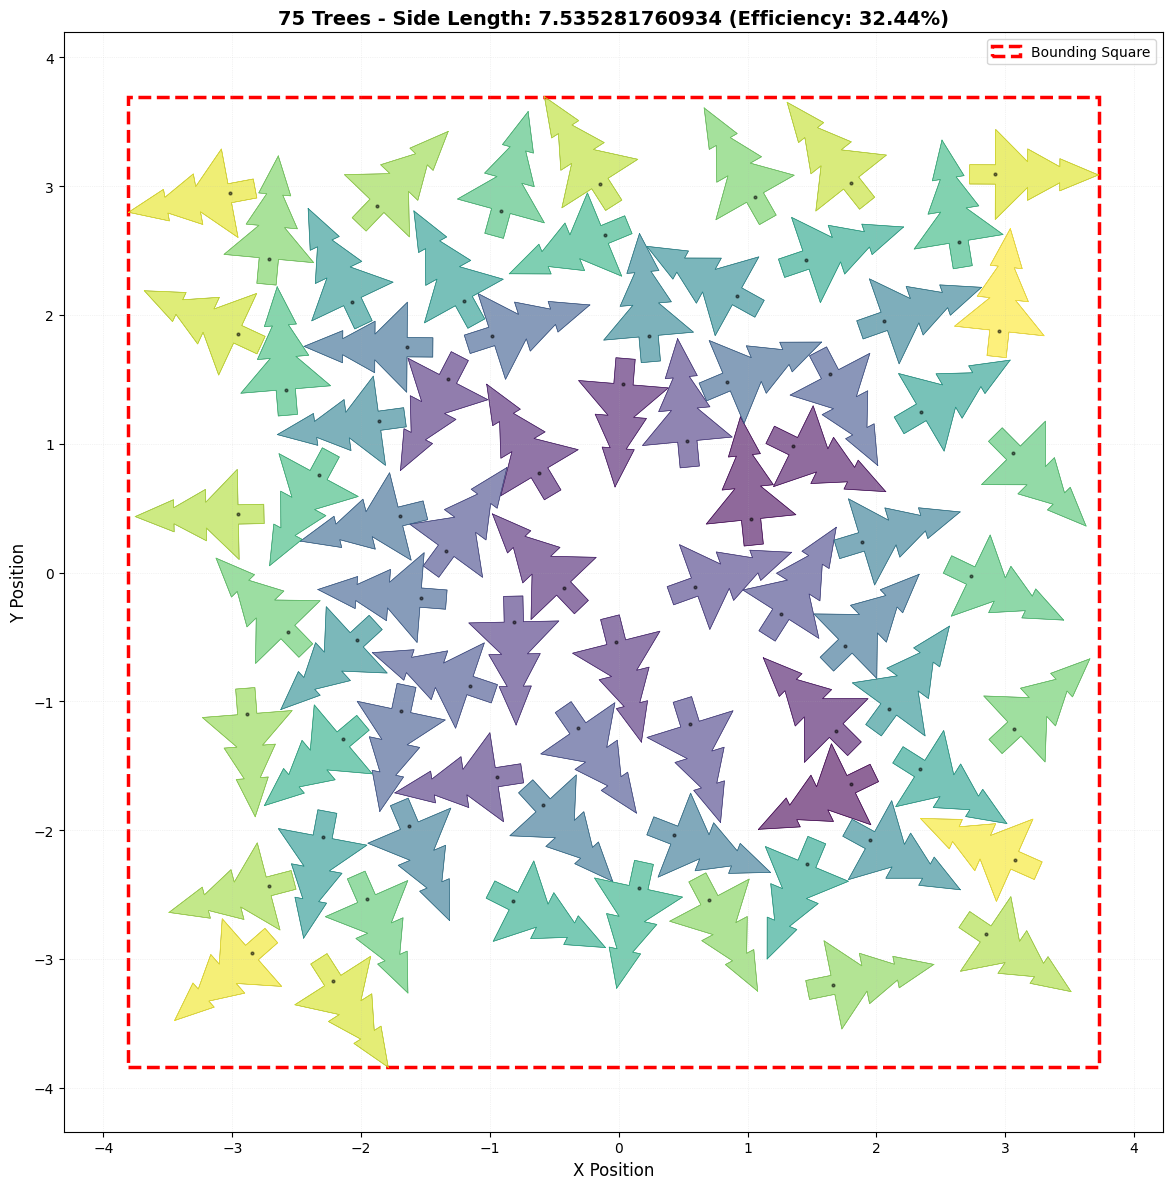

Processed 80 trees - Side Length: 7.640659418352, Efficiency: 33.66%
Processed 90 trees - Side Length: 8.122724690937, Efficiency: 33.51%
Processed 100 trees - Side Length: 8.386702458923, Efficiency: 34.92%

Plotting 100 trees...


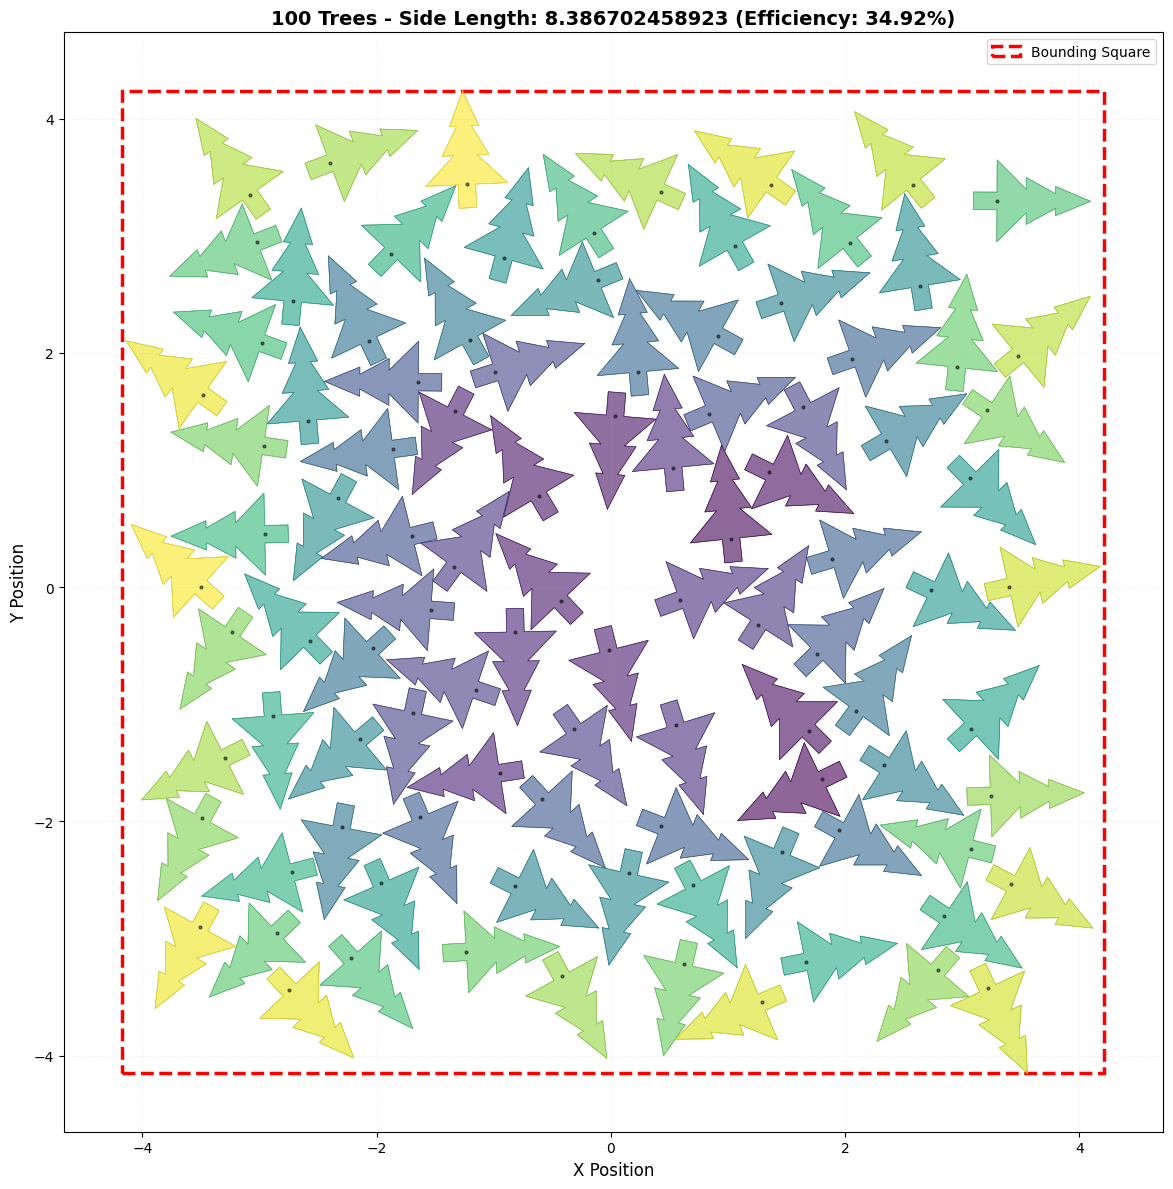

Processed 110 trees - Side Length: 8.830935588365, Efficiency: 34.65%
Processed 120 trees - Side Length: 9.146020219933, Efficiency: 35.24%

Plotting 125 trees...


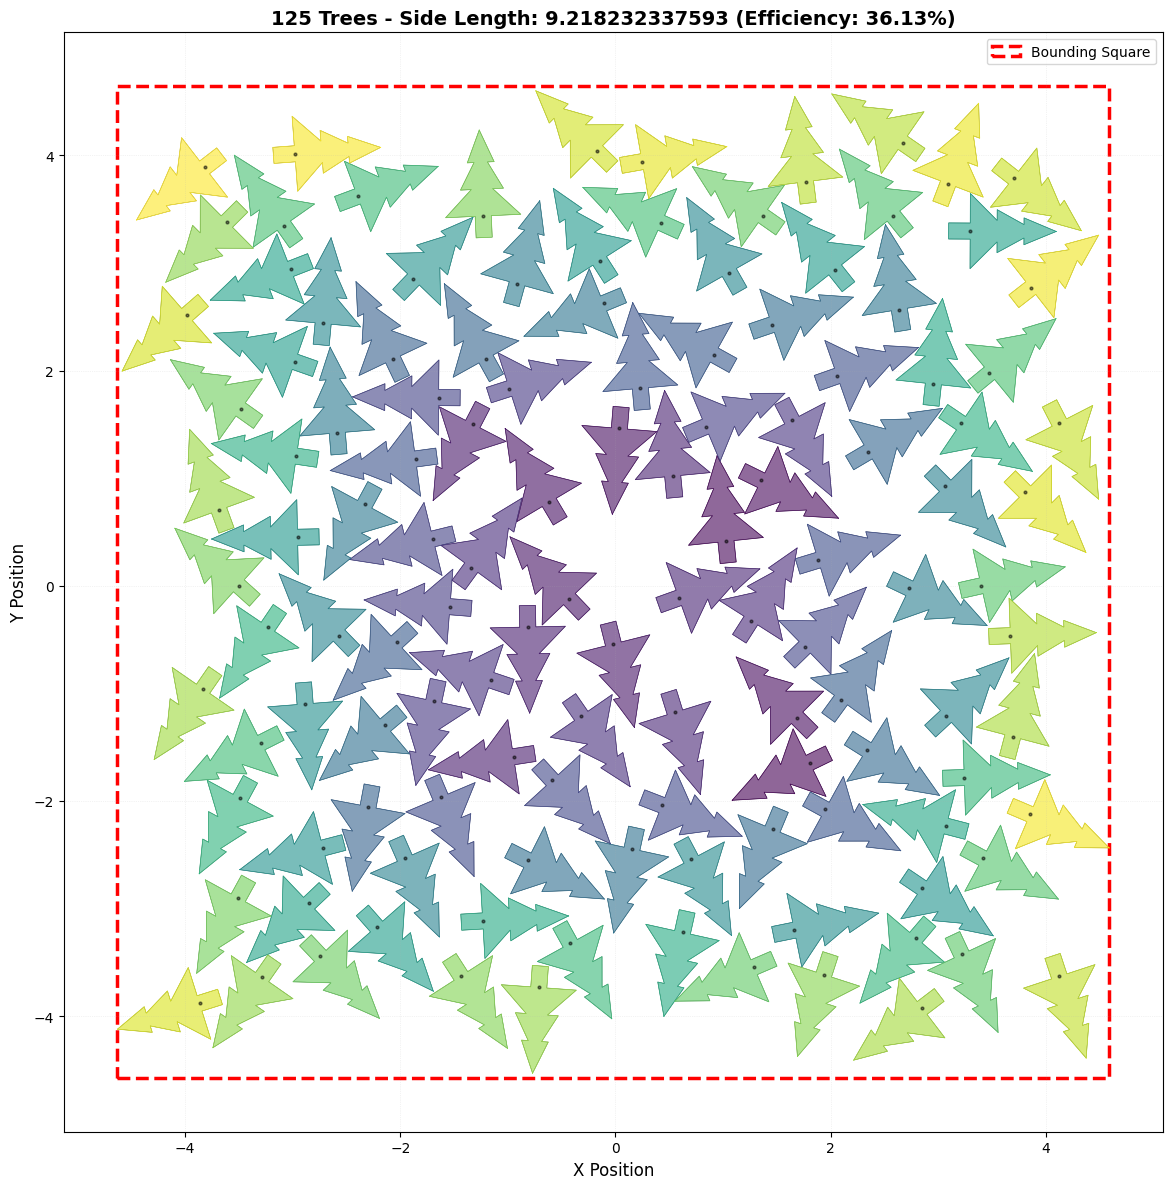

Processed 130 trees - Side Length: 9.532841689388, Efficiency: 35.14%
Processed 140 trees - Side Length: 9.903802175435, Efficiency: 35.06%
Processed 150 trees - Side Length: 10.205570733872, Efficiency: 35.37%

Plotting 150 trees...


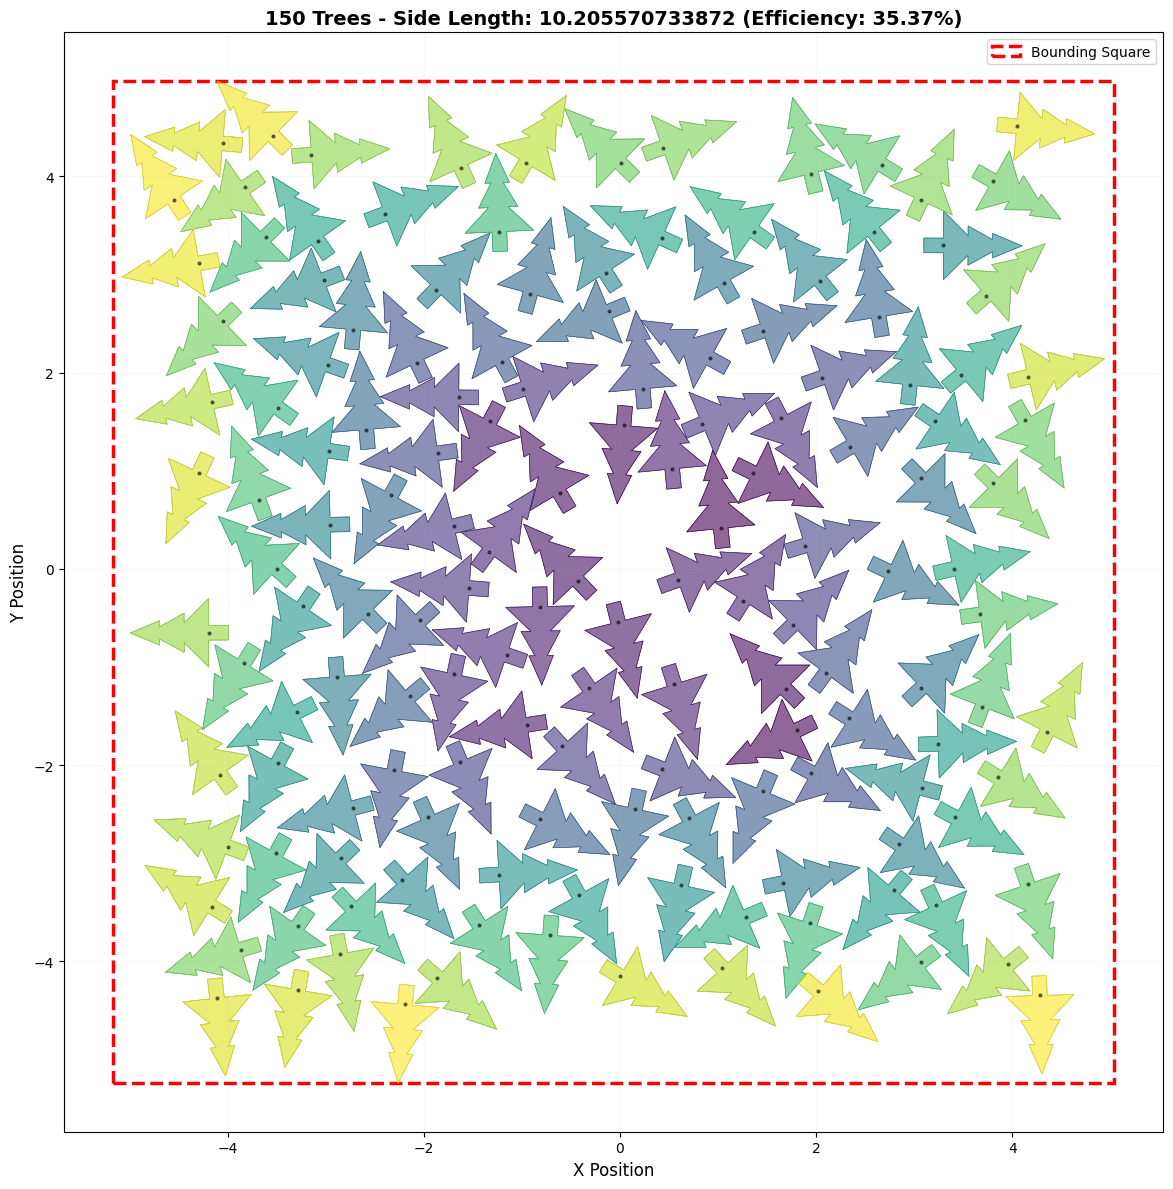

Processed 160 trees - Side Length: 10.706405394726, Efficiency: 34.29%
Processed 170 trees - Side Length: 10.783789485769, Efficiency: 35.91%

Plotting 175 trees...


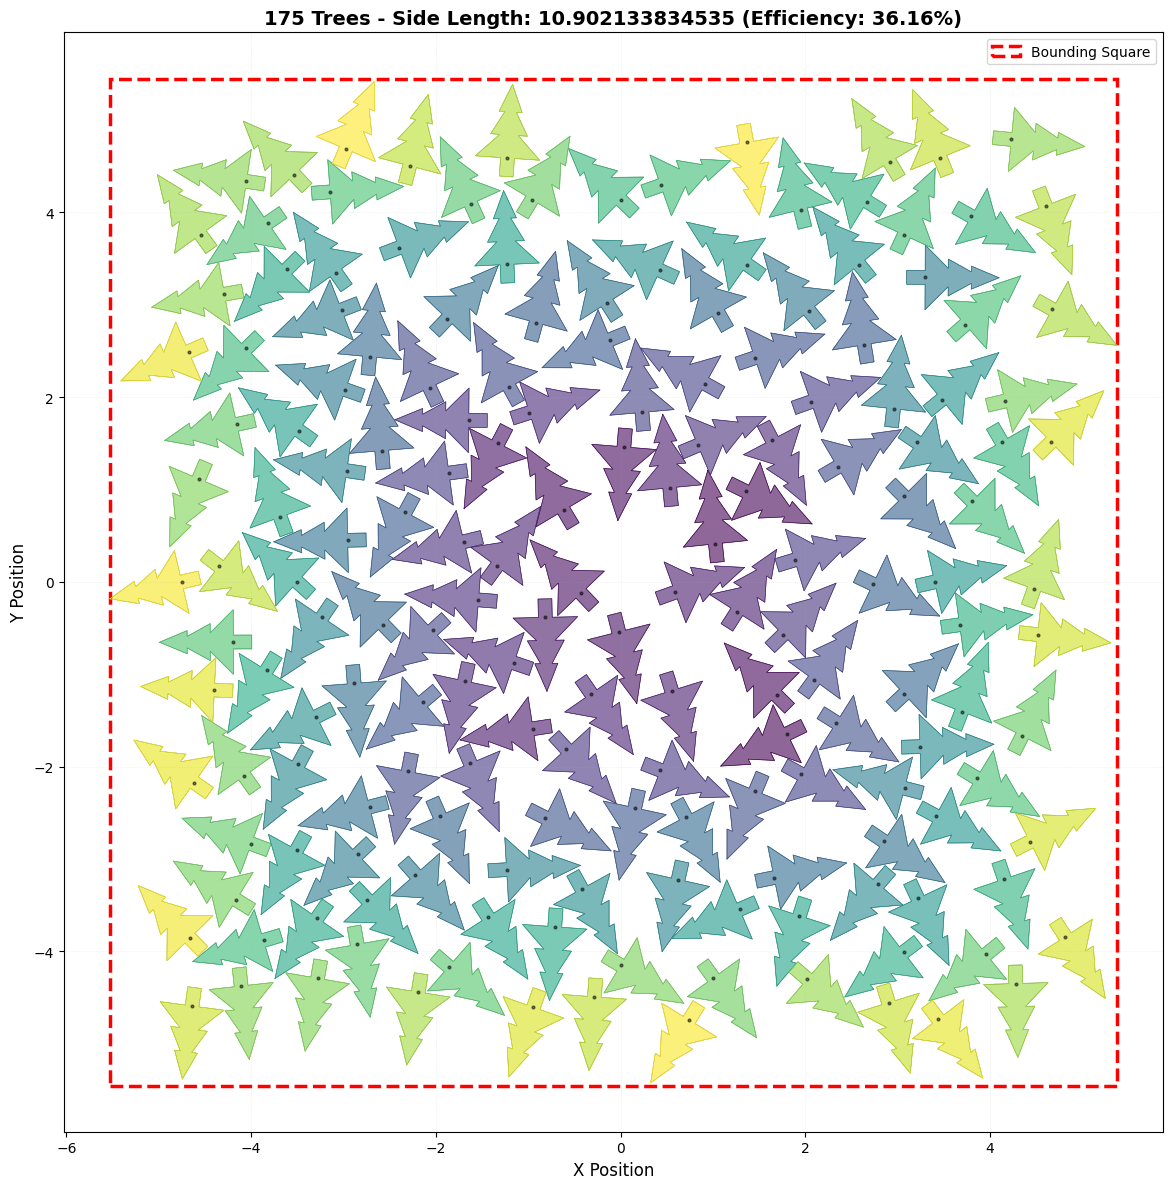

Processed 180 trees - Side Length: 11.037976241319, Efficiency: 36.29%
Processed 190 trees - Side Length: 11.317054493754, Efficiency: 36.44%
Processed 200 trees - Side Length: 11.523424316134, Efficiency: 36.99%

Plotting 200 trees...


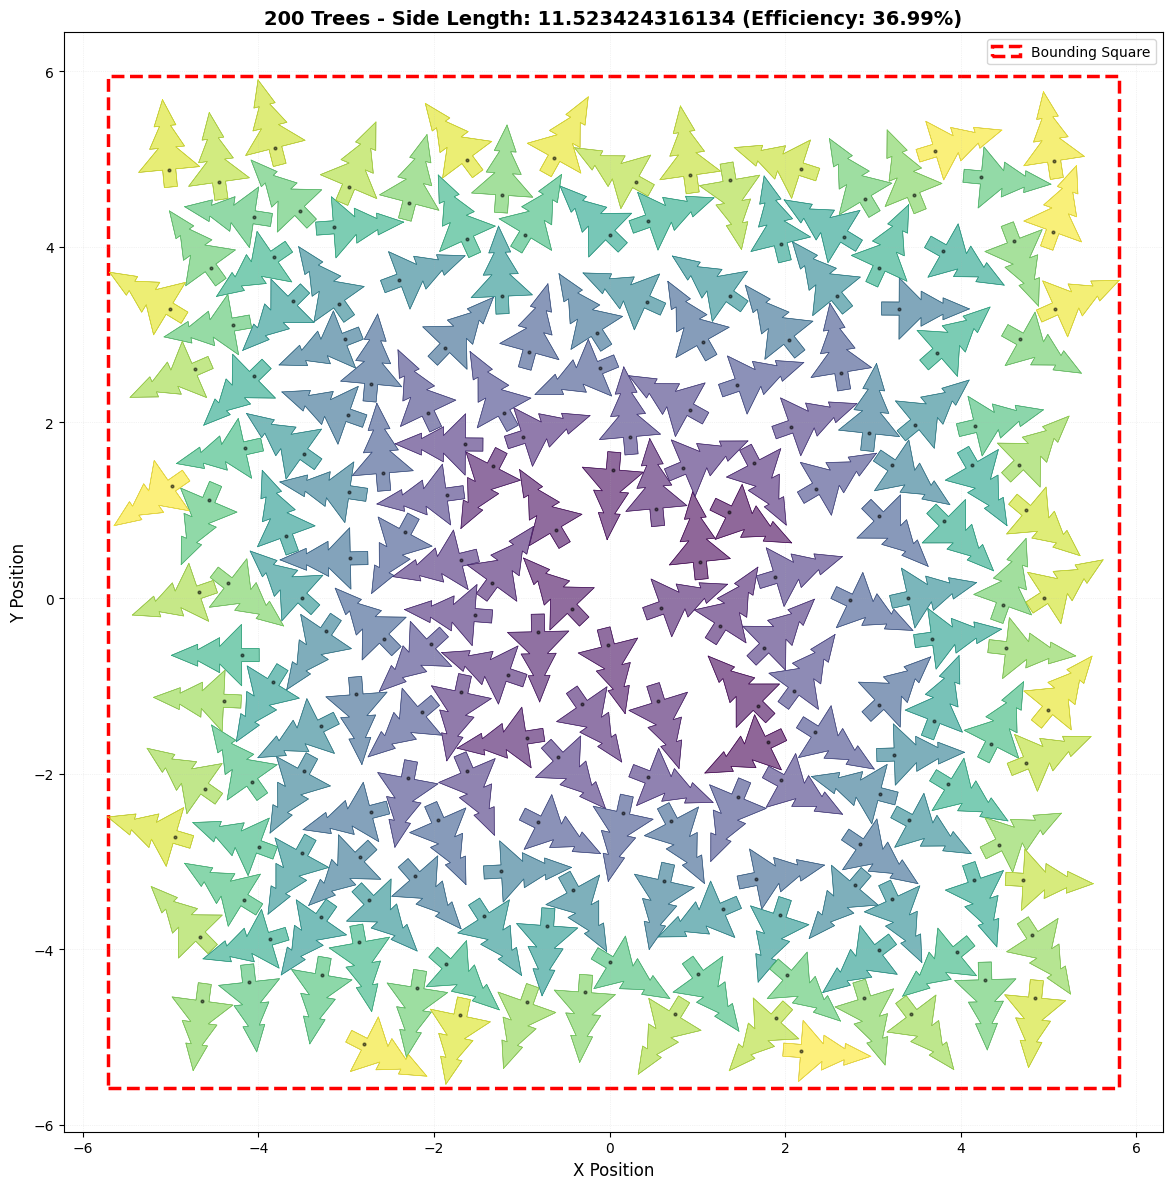


✓ Solution loaded and processed!


In [82]:
# Load solution from CSV file (using csv_path from previous cell)
print(f"Loading solution from: {csv_path}")
print("Processing CSV data...\n")

# Load CSV
df = pd.read_csv(csv_path, index_col='id')

# Parse values (strip 's' prefix and convert to float)
def parse_value(val):
    """Strip 's' prefix and convert to float."""
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

df['x'] = df['x'].apply(parse_value)
df['y'] = df['y'].apply(parse_value)
df['deg'] = df['deg'].apply(parse_value)

# Group by problem size (extract from index like "001_0" -> 1 tree problem)
def get_problem_size(idx):
    """Extract problem size from index (e.g., '001_0' -> 1)."""
    return int(idx.split('_')[0])

df['problem_size'] = df.index.map(get_problem_size)

# Reconstruct trees and calculate metrics incrementally
metrics_history = []
all_trees_by_problem = {}  # Store trees for each problem size
plot_points = [10, 25, 50, 75, 100, 125, 150, 175, 200]  # Plot at these tree counts

for n in range(1, 201):
    # Get trees for this problem size
    problem_df = df[df['problem_size'] == n].copy()
    
    # Create ChristmasTree objects
    placed_trees = []
    for idx, row in problem_df.iterrows():
        tree = ChristmasTree(
            center_x=str(row['x']),
            center_y=str(row['y']),
            angle=str(row['deg'])
        )
        placed_trees.append(tree)
    
    # Calculate side length
    side = compute_side_length(placed_trees)
    
    # Calculate metrics
    metrics = calculate_metrics(placed_trees, side)
    metrics_history.append(metrics)
    all_trees_by_problem[n] = placed_trees
    
    # Print progress
    if n % 10 == 0:
        print(f"Processed {n} trees - Side Length: {side:.12f}, Efficiency: {metrics['efficiency']:.2f}%")
    
    # Plot at specific intervals
    if n in plot_points:
        print(f"\nPlotting {n} trees...")
        plot_trees(placed_trees, side, n, title_suffix=f"(Efficiency: {metrics['efficiency']:.2f}%)")

# Store final trees for later visualization
current_placed_trees = all_trees_by_problem[200]

print("\n✓ Solution loaded and processed!")


In [83]:
## Calculate Kaggle Evaluation Score

# Official Kaggle Metric Formula:
# For each n-tree configuration: score = s^2 / n
# Where s = side length of square bounding box, n = number of trees
# Final score = sum of all s^2/n values for configurations n=1 to n=200
total_kaggle_score = Decimal('0')
individual_scores = []

for i, metrics in enumerate(metrics_history):
    n = i + 1  # n ranges from 1 to 200
    s = metrics['side_length']
    s_squared = s ** 2
    score = s_squared / n  # Official Kaggle formula: s^2 / n
    individual_scores.append(float(score))
    total_kaggle_score += score

print("=" * 80)
print("KAGGLE EVALUATION METRIC (Official Formula: s^2/n)")
print("=" * 80)
print(f"Formula: For each configuration n, calculate s^2/n, then sum all configurations")
print(f"Total Score (sum of s^2/n for all 200 configurations): {total_kaggle_score:.12f}")
print(f"Expected Kaggle Score: ~179")
print(f"Difference: {abs(float(total_kaggle_score) - 179):.12f}")
print()
print("Verification:")
print(f"  Number of configurations processed: {len(metrics_history)}")
print(f"  Sum of first 10 configs: {sum(individual_scores[:10]):.12f}")
print(f"  Sum of last 10 configs: {sum(individual_scores[-10:]):.12f}")
print(f"  Average score per config: {float(total_kaggle_score) / len(metrics_history):.12f}")
print()
print("Breakdown by configuration (sample):")
print("-" * 80)
print(f"{'n':<5} {'Side Length (s)':<20} {'s^2':<20} {'s^2/n':<20}")
print("-" * 80)

# Show first 10, last 10, and some key points
key_points = [1, 2, 3, 4, 5, 10, 25, 50, 75, 100, 125, 150, 175, 190, 195, 196, 197, 198, 199, 200]
for n in key_points:
    if n <= len(metrics_history):
        m = metrics_history[n-1]
        s = m['side_length']
        s_squared = s ** 2
        score = s_squared / n
        print(f"{n:<5} {float(s):<20.12f} {float(s_squared):<20.12f} {float(score):<20.12f}")

print("-" * 80)
print(f"{'TOTAL':<5} {'':<20} {'':<20} {float(total_kaggle_score):<20.12f}")
print("=" * 80)


KAGGLE EVALUATION METRIC (Official Formula: s^2/n)
Formula: For each configuration n, calculate s^2/n, then sum all configurations
Total Score (sum of s^2/n for all 200 configurations): 153.324862820267
Expected Kaggle Score: ~179
Difference: 25.675137179733

Verification:
  Number of configurations processed: 200
  Sum of first 10 configs: 11.834952407810
  Sum of last 10 configs: 6.742571510707
  Average score per config: 0.766624314101

Breakdown by configuration (sample):
--------------------------------------------------------------------------------
n     Side Length (s)      s^2                  s^2/n               
--------------------------------------------------------------------------------
1     0.965665763300       0.932510366409       0.932510366409      
2     1.619251545807       2.621975568597       1.310987784299      
3     1.484953197433       2.205085998567       0.735028666189      
4     1.932065308470       3.732876356195       0.933219089049      
5     2.2377

## Visualize Metrics Over Time


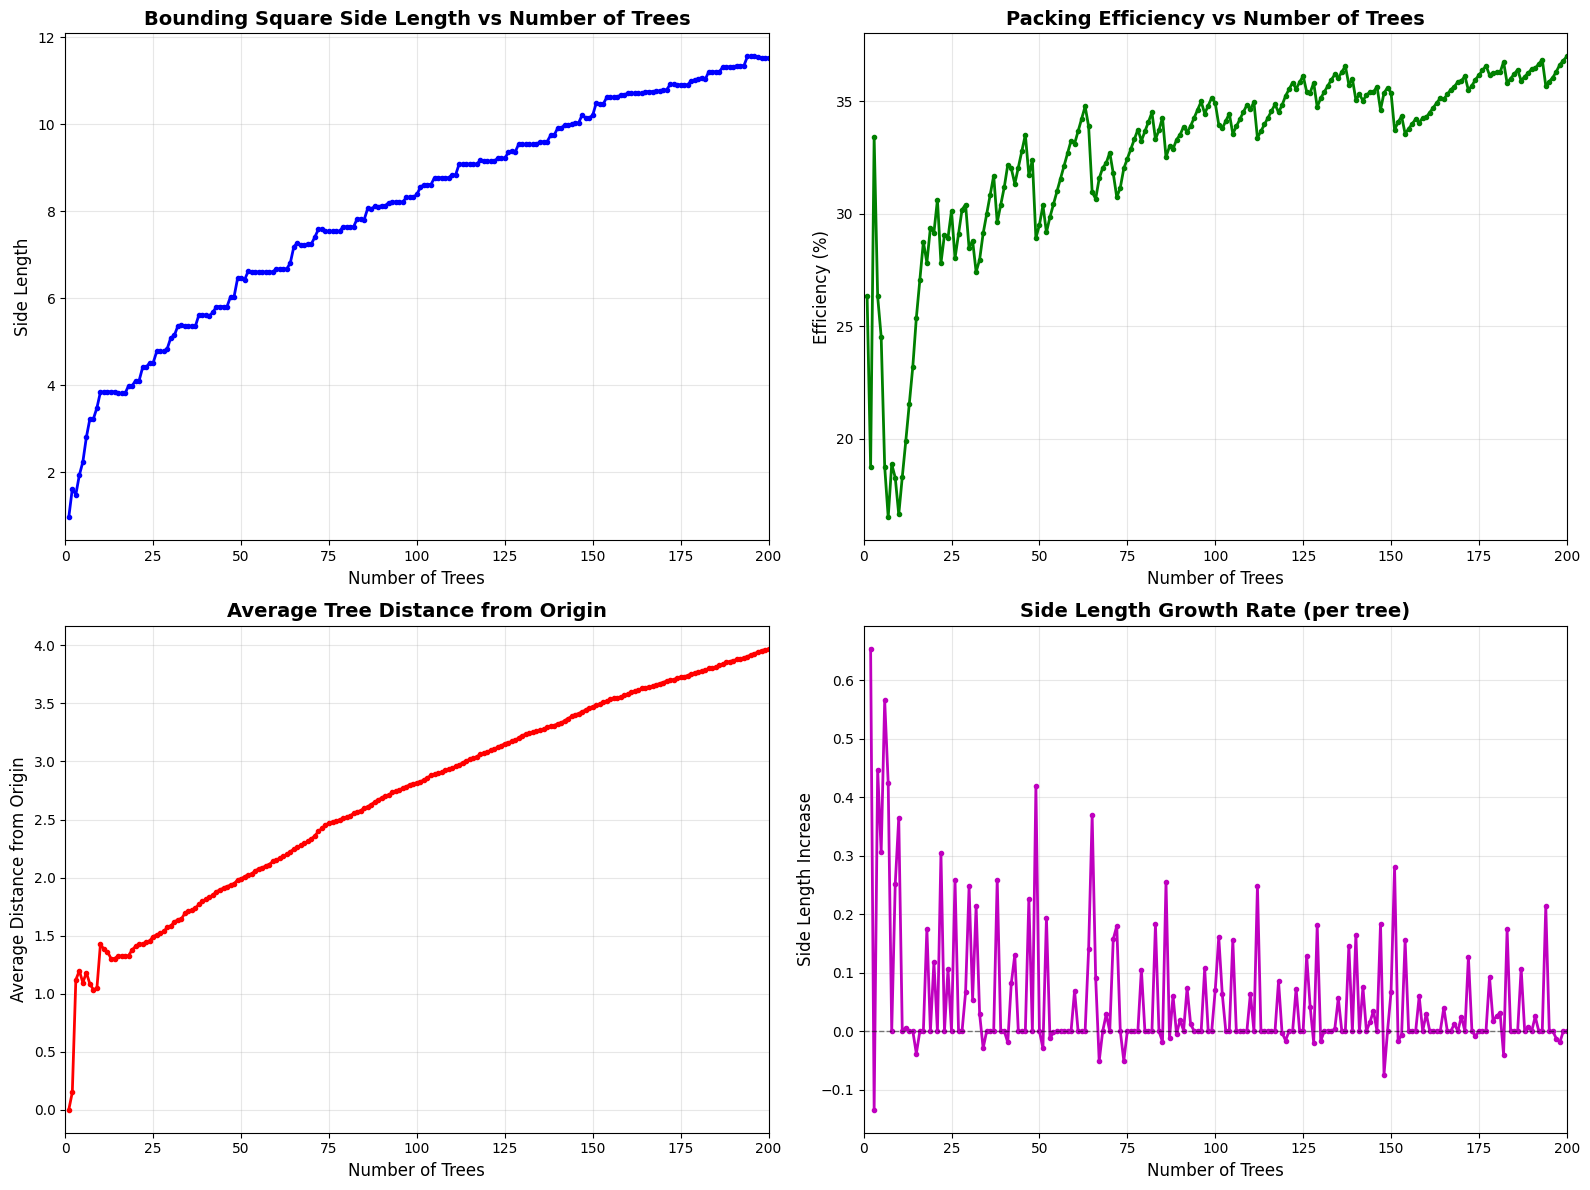

In [84]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_history)

# Convert Decimal columns to float for plotting
for col in metrics_df.columns:
    if metrics_df[col].dtype == 'object':
        metrics_df[col] = metrics_df[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Create comprehensive metrics plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Side Length over time
axes[0, 0].plot(metrics_df['num_trees'], metrics_df['side_length'], 'b-', linewidth=2, marker='o', markersize=3)
axes[0, 0].set_xlabel('Number of Trees', fontsize=12)
axes[0, 0].set_ylabel('Side Length', fontsize=12)
axes[0, 0].set_title('Bounding Square Side Length vs Number of Trees', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 200)

# 2. Efficiency over time
axes[0, 1].plot(metrics_df['num_trees'], metrics_df['efficiency'], 'g-', linewidth=2, marker='o', markersize=3)
axes[0, 1].set_xlabel('Number of Trees', fontsize=12)
axes[0, 1].set_ylabel('Efficiency (%)', fontsize=12)
axes[0, 1].set_title('Packing Efficiency vs Number of Trees', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 200)

# 3. Average Distance from Origin
axes[1, 0].plot(metrics_df['num_trees'], metrics_df['avg_distance_from_origin'], 'r-', linewidth=2, marker='o', markersize=3)
axes[1, 0].set_xlabel('Number of Trees', fontsize=12)
axes[1, 0].set_ylabel('Average Distance from Origin', fontsize=12)
axes[1, 0].set_title('Average Tree Distance from Origin', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 200)

# 4. Side Length Growth Rate (derivative)
side_length_diff = metrics_df['side_length'].diff()
axes[1, 1].plot(metrics_df['num_trees'][1:], side_length_diff[1:], 'm-', linewidth=2, marker='o', markersize=3)
axes[1, 1].set_xlabel('Number of Trees', fontsize=12)
axes[1, 1].set_ylabel('Side Length Increase', fontsize=12)
axes[1, 1].set_title('Side Length Growth Rate (per tree)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 200)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()


## Detailed Metrics Table


In [85]:
# Display metrics at key intervals
key_points = [10, 25, 50, 75, 100, 125, 150, 175, 200]
display_df = metrics_df[metrics_df['num_trees'].isin(key_points)].copy()

# Format for display
display_df['side_length'] = display_df['side_length'].apply(lambda x: f"{x:.12f}")
display_df['efficiency'] = display_df['efficiency'].apply(lambda x: f"{x:.2f}%")
display_df['avg_distance_from_origin'] = display_df['avg_distance_from_origin'].apply(lambda x: f"{x:.6f}")
display_df['max_distance_from_origin'] = display_df['max_distance_from_origin'].apply(lambda x: f"{x:.6f}")
display_df['kaggle_score'] = display_df['kaggle_score'].apply(lambda x: f"{x:.12f}")

print("Metrics at Key Intervals:")
print("=" * 100)
display(display_df[['num_trees', 'side_length', 'efficiency', 'kaggle_score', 'avg_distance_from_origin', 'max_distance_from_origin']])


Metrics at Key Intervals:


num_trees      side_length efficiency    kaggle_score  \
9           10   3.843449972485     16.63%  1.477210769100   
24          25   4.514554480751     30.13%  0.815248086387   
49          50   6.451998118063     29.50%  0.832565594310   
74          75   7.535281760934     32.44%  0.757072949556   
99         100   8.386702458923     34.92%  0.703367781345   
124        125   9.218232337593     36.13%  0.679806459439   
149        150  10.205570733872     35.37%  0.694357826694   
174        175  10.902133834535     36.16%  0.679180126549   
199        200  11.523424316134     36.99%  0.663946539848   

    avg_distance_from_origin max_distance_from_origin  
9                   1.428223                 2.440788  
24                  1.492029                 2.440788  
49                  1.989287                 3.450000  
74                  2.468045                 4.255021  
99                  2.816636                 4.700000  
124                 3.154403                 5.495080  
149                 3.472234                 6.100000  
174                 3.725742                 6.525136  
199                 3.970101                 7.100000

## Final Solution Visualization


Final Solution Metrics:
  Number of Trees: 200
  Side Length: 11.523424316134
  Efficiency: 36.99%
  Kaggle Score (s^2/n): 0.663946539848
  Average Distance from Origin: 3.970101
  Max Distance from Origin: 7.100000



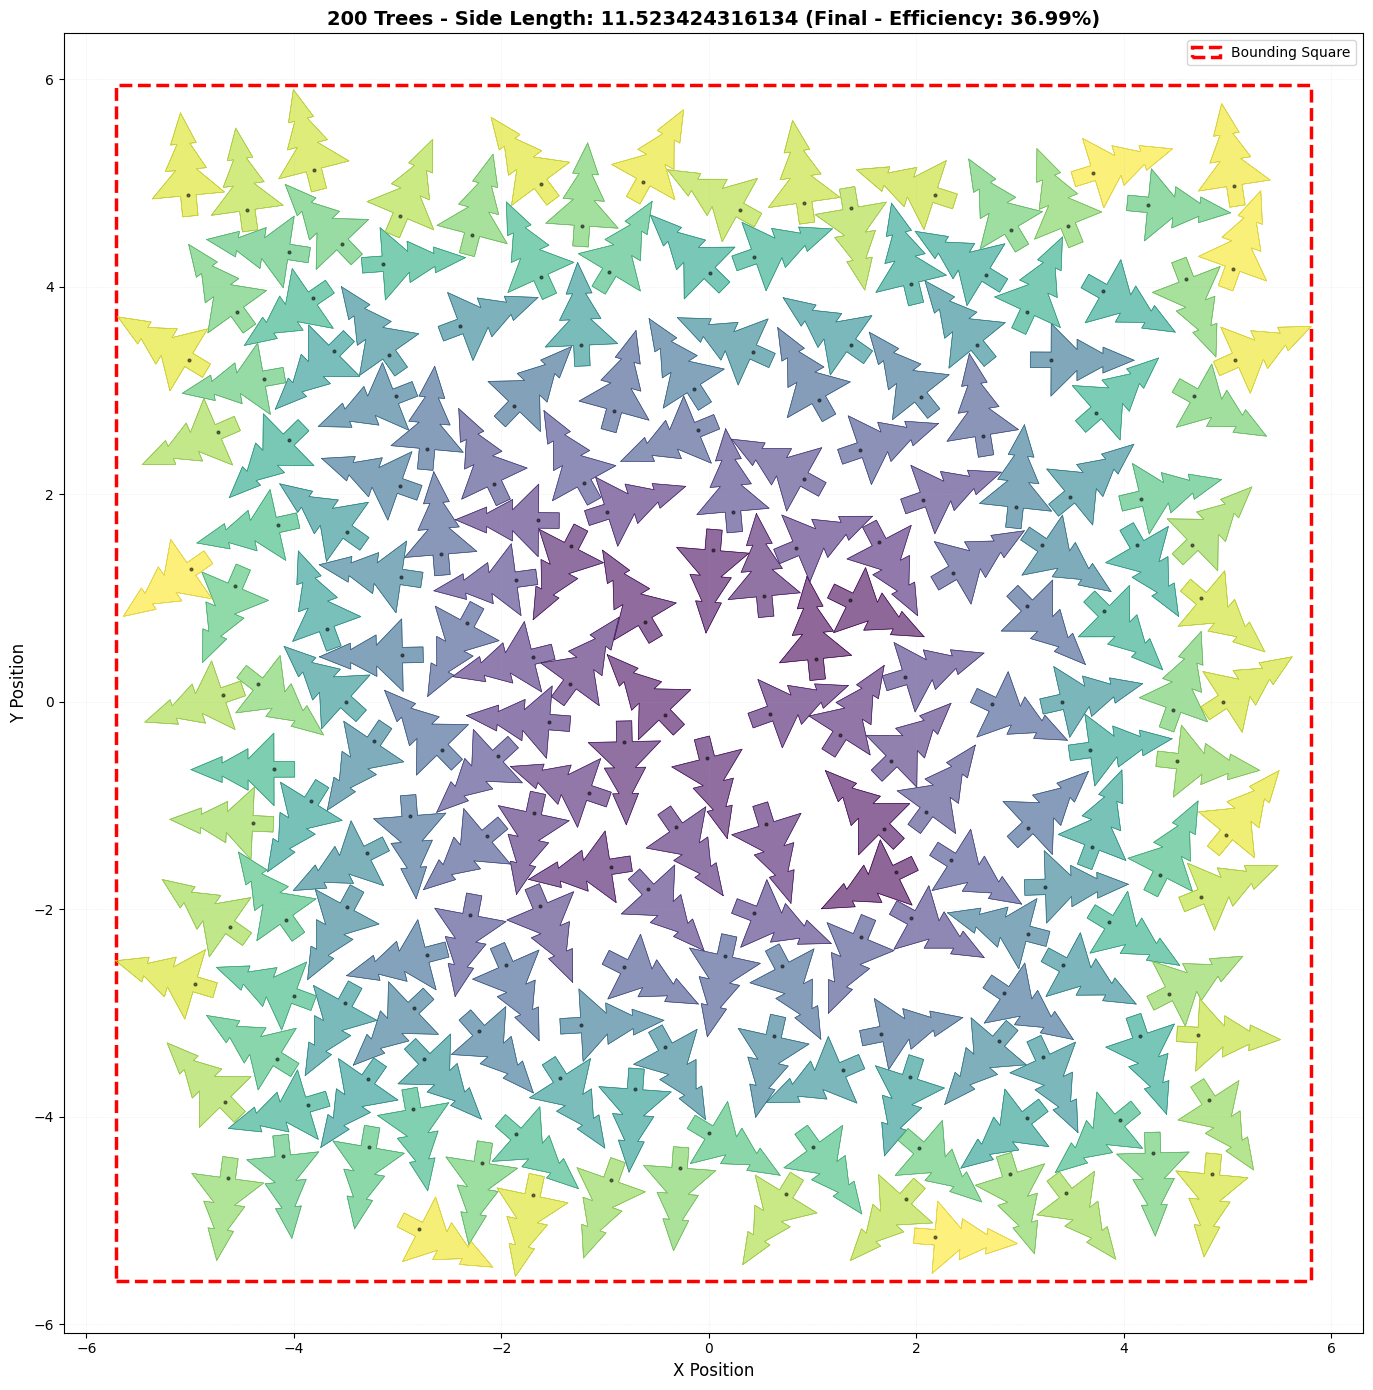

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': '200 Trees - Side Length: 11.523424316134 (Final - Efficiency: 36.99%)'}, xlabel='X Position', ylabel='Y Position'>)

In [86]:
# Plot final solution (200 trees)
final_metrics = metrics_history[-1]
print(f"Final Solution Metrics:")
print(f"  Number of Trees: {final_metrics['num_trees']}")
print(f"  Side Length: {final_metrics['side_length']:.12f}")
print(f"  Efficiency: {final_metrics['efficiency']:.2f}%")
print(f"  Kaggle Score (s^2/n): {final_metrics['kaggle_score']:.12f}")
print(f"  Average Distance from Origin: {final_metrics['avg_distance_from_origin']:.6f}")
print(f"  Max Distance from Origin: {final_metrics['max_distance_from_origin']:.6f}")
print()

plot_trees(current_placed_trees, final_metrics['side_length'], 200, 
           title_suffix=f"(Final - Efficiency: {final_metrics['efficiency']:.2f}%)",
           figsize=(14, 14))


## Additional Analysis: Tree Distributionone 

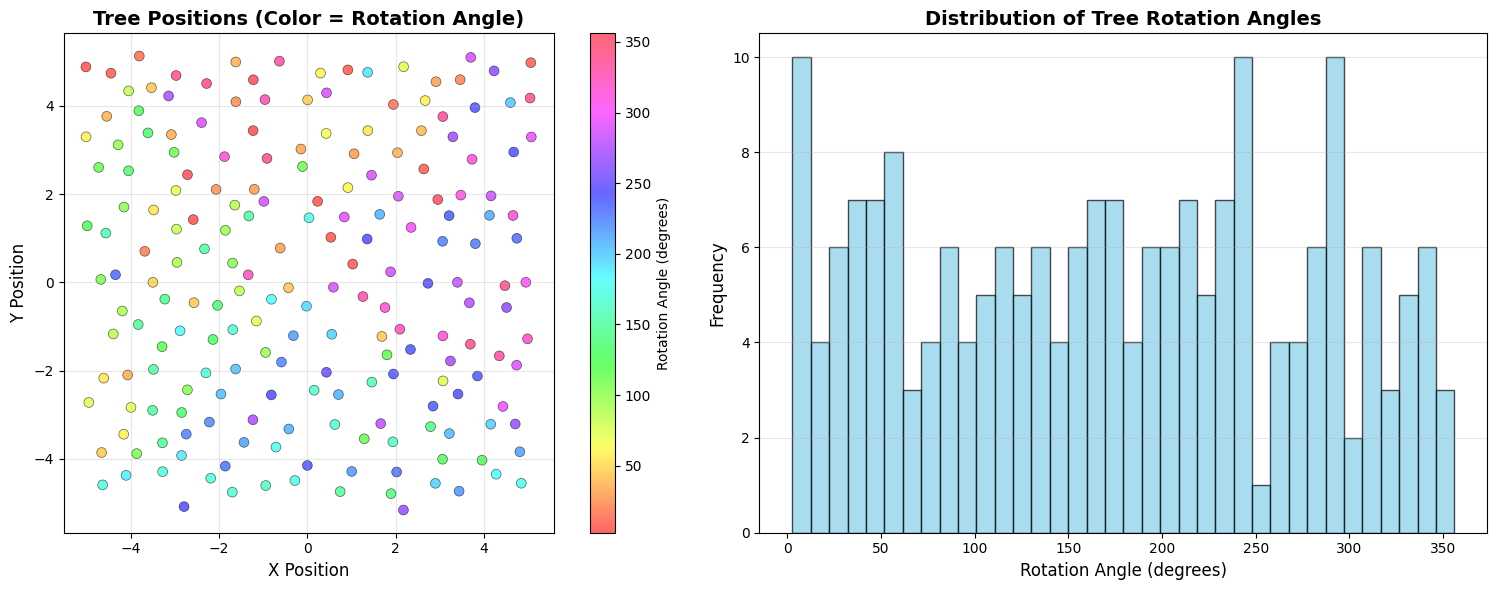

Tree Position Statistics:
  X Position - Min: -5.017289, Max: 5.074858, Mean: -0.021045
  Y Position - Min: -5.159474, Max: 5.127328, Mean: 0.097473
  Rotation Angle - Min: 2.64°, Max: 356.04°, Mean: 171.45°


In [87]:
# Analyze tree distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extract positions
x_positions = [float(tree.center_x) for tree in current_placed_trees]
y_positions = [float(tree.center_y) for tree in current_placed_trees]
angles = [float(tree.angle) for tree in current_placed_trees]

# 1. Scatter plot of tree positions
scatter = axes[0].scatter(x_positions, y_positions, c=angles, cmap='hsv', 
                         s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('X Position', fontsize=12)
axes[0].set_ylabel('Y Position', fontsize=12)
axes[0].set_title('Tree Positions (Color = Rotation Angle)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal', adjustable='box')
plt.colorbar(scatter, ax=axes[0], label='Rotation Angle (degrees)')

# 2. Histogram of rotation angles
axes[1].hist(angles, bins=36, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].set_xlabel('Rotation Angle (degrees)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Tree Rotation Angles', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("Tree Position Statistics:")
print(f"  X Position - Min: {min(x_positions):.6f}, Max: {max(x_positions):.6f}, Mean: {np.mean(x_positions):.6f}")
print(f"  Y Position - Min: {min(y_positions):.6f}, Max: {max(y_positions):.6f}, Mean: {np.mean(y_positions):.6f}")
print(f"  Rotation Angle - Min: {min(angles):.2f}°, Max: {max(angles):.2f}°, Mean: {np.mean(angles):.2f}°")


## Overlap Detection and Visualization


In [88]:
def check_overlaps(placed_trees, verbose=True):
    """
    Check for overlaps between trees and return detailed overlap information.
    
    Returns:
    - overlap_pairs: List of (i, j) tuples indicating which trees overlap
    - overlap_areas: Dictionary mapping (i, j) to overlap area
    - total_overlap_area: Total area of all overlaps
    """
    overlap_pairs = []
    overlap_areas = {}
    total_overlap_area = Decimal('0')
    
    num_trees = len(placed_trees)
    if num_trees == 0:
        return overlap_pairs, overlap_areas, total_overlap_area
    
    # Use STRtree for efficient spatial queries
    all_polygons = [t.polygon for t in placed_trees]
    tree_index = STRtree(all_polygons)
    
    # Check each tree against others
    for i in range(num_trees):
        tree_i = placed_trees[i]
        poly_i = all_polygons[i]
        
        # Query for potentially intersecting trees
        possible_indices = tree_index.query(poly_i)
        
        for j in possible_indices:
            if j <= i:  # Avoid checking pairs twice
                continue
            
            tree_j = placed_trees[j]
            poly_j = all_polygons[j]
            
            # Check if trees intersect
            # Note: Check for ANY intersection, including touches, as Kaggle may flag these
            # We check both intersects() and whether they're just touching
            if poly_i.intersects(poly_j):
                # Calculate overlap area
                intersection = poly_i.intersection(poly_j)
                if hasattr(intersection, 'area'):
                    overlap_area = Decimal(str(intersection.area)) / (scale_factor ** 2)
                    is_touching = poly_i.touches(poly_j)
                    
                    # Flag as overlap if:
                    # 1. There's actual area overlap (> tiny threshold for precision), OR
                    # 2. They intersect but are not just touching (could be small overlap)
                    # Note: Even touches might be problematic if polygons are too close
                    if overlap_area > Decimal('1e-20'):
                        # Actual overlap with area
                        overlap_pairs.append((i, j))
                        overlap_areas[(i, j)] = overlap_area
                        total_overlap_area += overlap_area
                    elif not is_touching:
                        # Intersects but not touching - might be a very small overlap
                        # Report with area 0 to indicate potential issue
                        overlap_pairs.append((i, j))
                        overlap_areas[(i, j)] = Decimal('0')
                        # Don't add to total_area since it's 0
    
    if verbose:
        print("=" * 80)
        print("OVERLAP DETECTION RESULTS")
        print("=" * 80)
        print(f"Total number of trees: {num_trees}")
        print(f"Number of overlapping pairs: {len(overlap_pairs)}")
        print(f"Total overlap area: {float(total_overlap_area):.12f}")
        
        if overlap_pairs:
            print("\n⚠️  WARNING: Overlaps detected!")
            print("\nOverlapping pairs (tree indices):")
            for idx, (i, j) in enumerate(overlap_pairs[:20]):  # Show first 20
                area = overlap_areas[(i, j)]
                print(f"  Pair {idx+1}: Tree {i} <-> Tree {j}, Overlap area: {float(area):.12f}")
            if len(overlap_pairs) > 20:
                print(f"  ... and {len(overlap_pairs) - 20} more pairs")
        else:
            print("\n✓ No overlaps detected - solution is valid!")
        print("=" * 80)
    
    return overlap_pairs, overlap_areas, total_overlap_area


def plot_overlaps(placed_trees, side_length, overlap_pairs, overlap_areas, num_trees, figsize=(14, 14)):
    """
    Visualize trees with overlaps highlighted in red.
    
    Parameters:
    - placed_trees: List of ChristmasTree objects
    - side_length: Side length of bounding square
    - overlap_pairs: List of (i, j) tuples for overlapping trees
    - overlap_areas: Dictionary mapping (i, j) to overlap area
    - num_trees: Number of trees to display
    - figsize: Figure size tuple
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get all polygons
    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds
    
    # Create sets of overlapping tree indices for quick lookup
    overlapping_trees = set()
    for i, j in overlap_pairs:
        overlapping_trees.add(i)
        overlapping_trees.add(j)
    
    # Plot non-overlapping trees in normal colors
    colors = plt.cm.viridis([i / max(1, num_trees - 1) for i in range(num_trees)])
    
    for i, tree in enumerate(placed_trees):
        # Rescale for plotting
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        
        # Use red for overlapping trees, normal color for others
        if i in overlapping_trees:
            color = 'red'
            alpha = 0.8
            linewidth = 2.0
        else:
            color = colors[i]
            alpha = 0.5
            linewidth = 0.5
        
        ax.plot(x, y, color=color, linewidth=linewidth)
        ax.fill(x, y, alpha=alpha, color=color, edgecolor='black', linewidth=linewidth)
        
        # Optionally plot center point
        ax.plot(float(tree.center_x), float(tree.center_y), 'ko', markersize=2, alpha=0.5)
    
    # Highlight overlap regions in bright red
    for i, j in overlap_pairs:
        poly_i = all_polygons[i]
        poly_j = all_polygons[j]
        intersection = poly_i.intersection(poly_j)
        
        if hasattr(intersection, 'exterior'):
            # Single polygon intersection
            x_int, y_int = intersection.exterior.xy
            x_int_scaled = [Decimal(val) / scale_factor for val in x_int]
            y_int_scaled = [Decimal(val) / scale_factor for val in y_int]
            ax.fill(x_int_scaled, y_int_scaled, color='red', alpha=0.9, edgecolor='darkred', linewidth=2)
        elif hasattr(intersection, 'geoms'):
            # MultiPolygon intersection
            for geom in intersection.geoms:
                if hasattr(geom, 'exterior'):
                    x_int, y_int = geom.exterior.xy
                    x_int_scaled = [Decimal(val) / scale_factor for val in x_int]
                    y_int_scaled = [Decimal(val) / scale_factor for val in y_int]
                    ax.fill(x_int_scaled, y_int_scaled, color='red', alpha=0.9, edgecolor='darkred', linewidth=2)
    
    # Calculate bounding square position
    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor
    
    width = maxx - minx
    height = maxy - miny
    
    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    
    # Draw bounding square
    bounding_square = Rectangle(
        (float(square_x), float(square_y)),
        float(side_length),
        float(side_length),
        fill=False,
        edgecolor='blue',
        linewidth=2.5,
        linestyle='--',
        label='Bounding Square'
    )
    ax.add_patch(bounding_square)
    
    # Set plot limits with padding
    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding)))
    )
    ax.set_ylim(
        float(square_y - Decimal(str(padding))),
        float(square_y + side_length + Decimal(str(padding)))
    )
    
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    
    title = f'{num_trees} Trees - Overlap Detection'
    if overlap_pairs:
        title += f' (⚠️ {len(overlap_pairs)} overlapping pairs detected!)'
    else:
        title += ' (✓ No overlaps)'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.5, label='Normal trees'),
        Patch(facecolor='red', alpha=0.8, label='Overlapping trees'),
        Patch(facecolor='red', alpha=0.9, label='Overlap regions')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    return fig, ax


# Check for overlaps in ALL groups
print("=" * 80)
print("CHECKING ALL GROUPS FOR OVERLAPS")
print("=" * 80)

groups_with_overlaps = []
all_overlap_results = {}

for n in range(1, 201):
    if n in all_trees_by_problem:
        trees = all_trees_by_problem[n]
        overlap_pairs, overlap_areas, total_overlap = check_overlaps(trees, verbose=False)
        
        if overlap_pairs:
            groups_with_overlaps.append(n)
            all_overlap_results[n] = {
                'pairs': overlap_pairs,
                'areas': overlap_areas,
                'total_area': total_overlap
            }
            print(f"⚠️  Group {n:03d} ({n} trees): {len(overlap_pairs)} overlapping pairs, total overlap area: {float(total_overlap):.12f}")

print("\n" + "=" * 80)
if groups_with_overlaps:
    print(f"⚠️  WARNING: Found overlaps in {len(groups_with_overlaps)} groups:")
    for n in groups_with_overlaps:
        print(f"  - Group {n:03d} ({n} trees): {len(all_overlap_results[n]['pairs'])} overlapping pairs")
else:
    print("✓ No overlaps detected in any group - solution is valid!")
print("=" * 80)

CHECKING ALL GROUPS FOR OVERLAPS

✓ No overlaps detected in any group - solution is valid!
